In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [48]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 50
EPOCHS = 50
N_CLASSES = 4

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "D:\Project\Apple",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3171 files belonging to 4 classes.


In [10]:
class_names = dataset.class_names
class_names

['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(50, 256, 256, 3)
[3 1 3 3 3 0 3 3 3 0 3 0 3 3 2 0 1 3 3 1 3 3 3 0 1 3 2 2 3 1 1 1 3 0 3 3 3
 1 3 3 3 3 3 1 3 1 2 1 3 3]


In [12]:
# Create a mapping between numerical labels and class names
class_names = {0: 'Apple Scab', 1: 'Black Rot', 2: 'Cedar Apple Rust',3:'Healthy'}

unique_labels = set()

for _, labels_batch in dataset.take(1):
    unique_labels.update(labels_batch.numpy())

print("Unique Labels/Classes in the Dataset:", unique_labels)

# Convert numerical labels to class names for visualization
class_names_batch = [class_names[label] for label in labels_batch.numpy()]


Unique Labels/Classes in the Dataset: {0, 1, 2, 3}


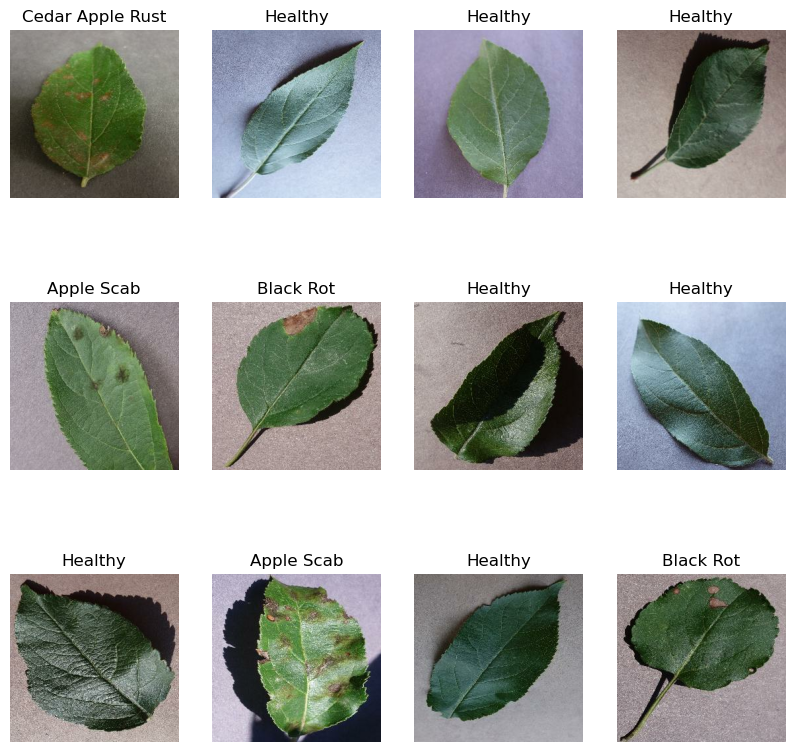

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):  # Display examples from 3 batches
    labels_batch_np = labels_batch.numpy()  # Convert the entire labels_batch tensor to a NumPy array
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # 3 batches * 4 subplots per batch
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Use the NumPy array as an index in the class_names dictionary
        label_key = labels_batch_np[i]
        plt.title(class_names[label_key])
        
        plt.axis("off")

plt.show()

In [14]:
len(dataset)

64

In [15]:
train_size = 0.8
len(dataset)*train_size

51.2

In [16]:
train_ds = dataset.take(51)
len(train_ds)

51

In [17]:
test_ds = dataset.skip(51)
len(test_ds)

13

In [18]:
val_size=0.1
len(dataset)*val_size

6.4

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

51

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

7

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [28]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4), 
])

In [29]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (50, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (50, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (50, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (50, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (50, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (50, 60, 60, 64)         

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,  # Adjust the patience parameter
    restore_best_weights=True,
    monitor='val_loss'
)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
  history = model.fit(
        train_ds_augmented,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )

Epoch 1/50
51/51 [==============================] - 99s 2s/step - loss: 0.2821 - accuracy: 0.9055 - val_loss: 0.3369 - val_accuracy: 0.8967
Epoch 2/50
51/51 [==============================] - 108s 2s/step - loss: 0.2088 - accuracy: 0.9259 - val_loss: 0.2232 - val_accuracy: 0.9300
Epoch 3/50
51/51 [==============================] - 97s 2s/step - loss: 0.2213 - accuracy: 0.9247 - val_loss: 0.3332 - val_accuracy: 0.9233
Epoch 4/50
51/51 [==============================] - 79s 2s/step - loss: 0.2041 - accuracy: 0.9310 - val_loss: 0.2089 - val_accuracy: 0.9367
Epoch 5/50
51/51 [==============================] - 76s 1s/step - loss: 0.1861 - accuracy: 0.9369 - val_loss: 0.2269 - val_accuracy: 0.9167
Epoch 6/50
51/51 [==============================] - 76s 1s/step - loss: 0.1651 - accuracy: 0.9451 - val_loss: 0.3390 - val_accuracy: 0.9167
Epoch 7/50
51/51 [==============================] - 78s 2s/step - loss: 0.1833 - accuracy: 0.9392 - val_loss: 0.2190 - val_accuracy: 0.9433
Epoch 8/50
51/51 [=

In [50]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 3s 400ms/step - loss: 0.0845 - accuracy: 0.9743


In [51]:
score = model.evaluate(train_ds)

51/51 [==============================] - 20s 397ms/step - loss: 0.1254 - accuracy: 0.9631


In [52]:
scores

[0.08453907072544098, 0.9742857217788696]

In [53]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
type(history.history['loss'])

list

In [57]:
len(history.history['loss'])

30

In [58]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.28213566541671753,
 0.20881295204162598,
 0.22134923934936523,
 0.20409153401851654,
 0.18611162900924683]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

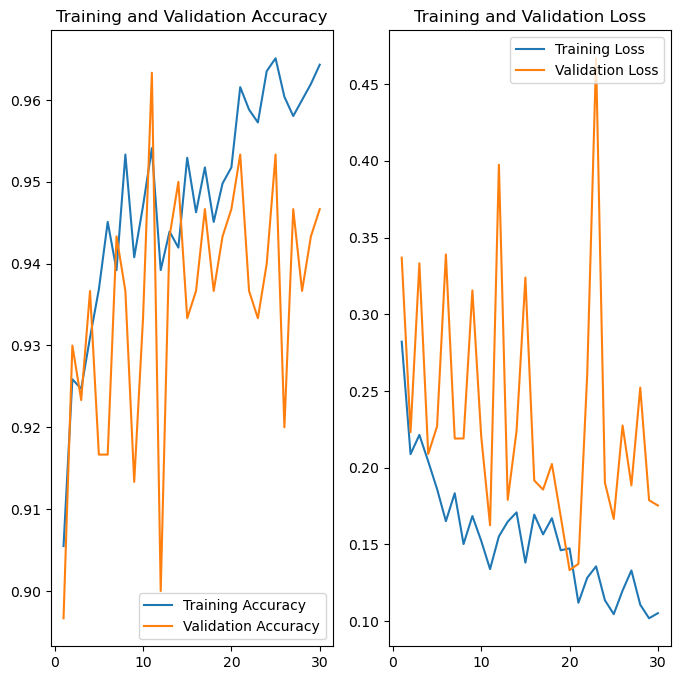

In [60]:
epochs = range(1, len(acc) + 1)  

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Black Rot
2/2 [==============================] - 1s 503ms/step
predicted label: Black Rot


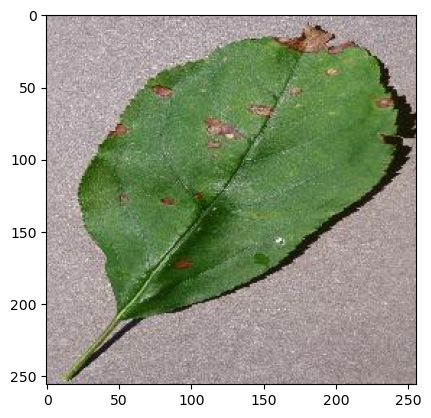

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


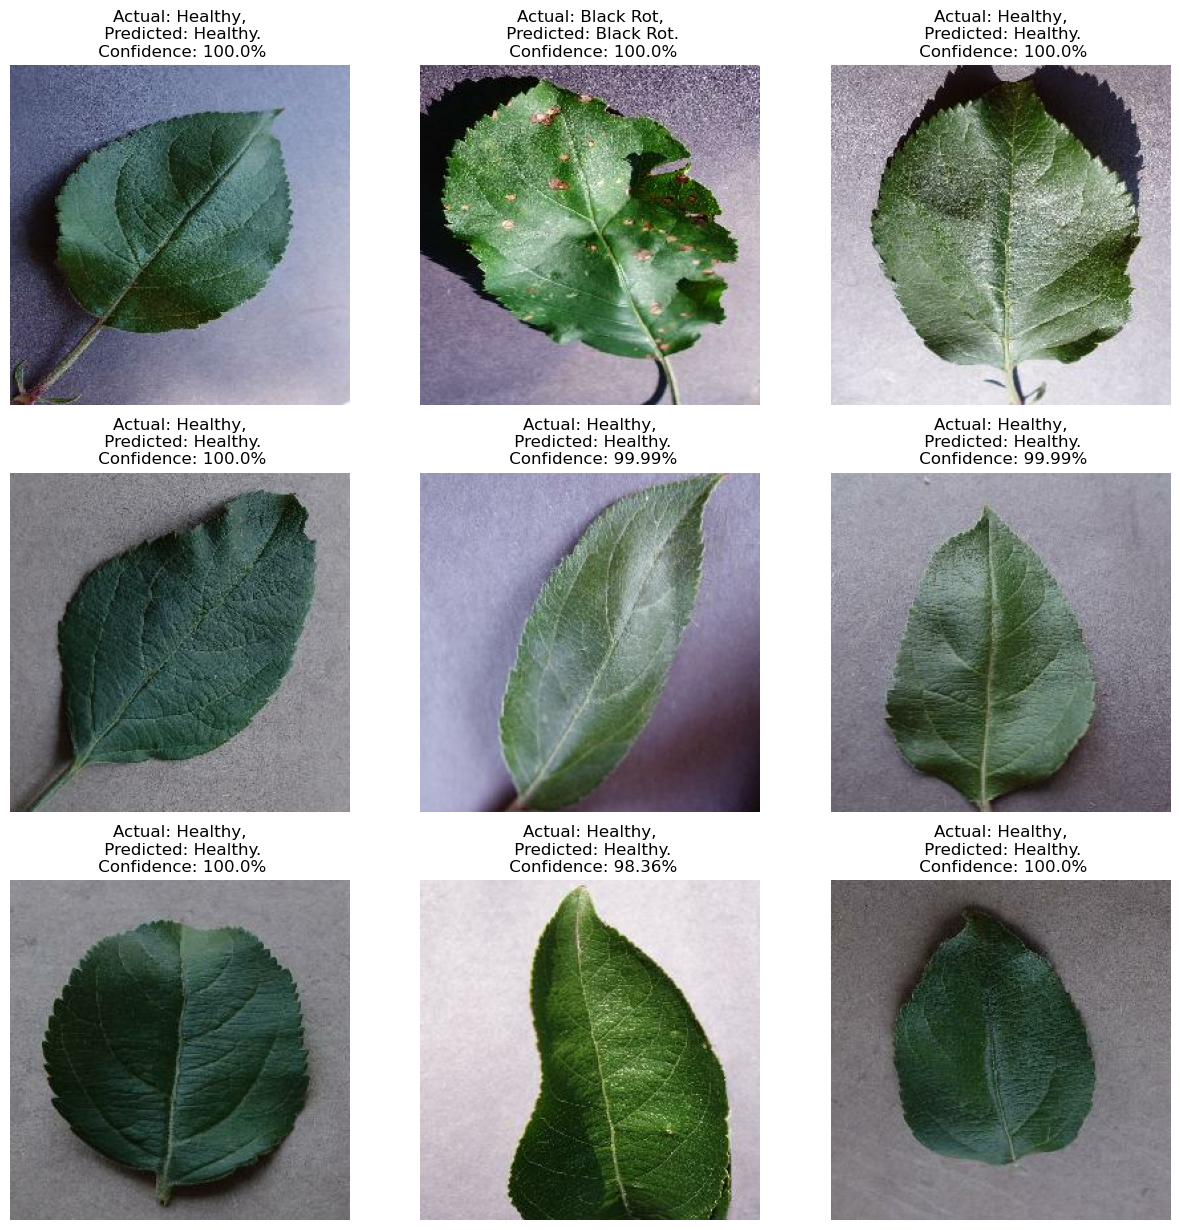

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]

        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [86]:
model.save("D:\Project\MODEL1\Plant_Disease.h5")

In [87]:
keras_model = tf.keras.models.load_model("D:\Project\MODEL1\Plant_Disease.h5")

In [88]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmplraizvn5\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmplraizvn5\assets


In [89]:
with open("D:\Project\MODEL1\Plant_Disease.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)